In [1]:
import torch
import torch.distributions as dist
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from scipy import stats
import matplotlib.pyplot as plt
from flows import Planar
import numpy as np

/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


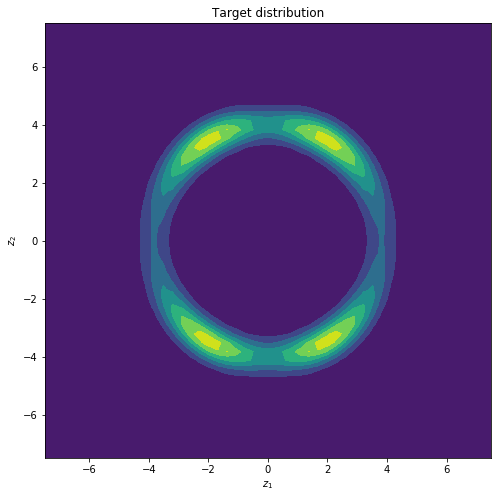

In [2]:
def target_density(z):
    z1, z2 = z[..., 0], z[..., 1]
    norm = (z1**2 + z2**2)**0.5
    exp1 = torch.exp(-0.2 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.2 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

x1 = np.linspace(-7.5, 7.5)
x2 = np.linspace(-7.5, 7.5)
x1_s, x2_s = np.meshgrid(x1, x2)
x_field = np.concatenate([x1_s[..., None], x2_s[..., None]], axis=-1)
x_field = torch.tensor(x_field, dtype=torch.float)

plt.figure(figsize=(8, 8))
plt.title("Target distribution")
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.contourf(x1_s, x2_s, target_density(x_field))
plt.show()

In [3]:
def det_loss(mu, log_var, z_0, z_k, ldj, beta):
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function
    batch_size = z_0.size(0)

    # Qz0
    log_qz0 = dist.Normal(mu, torch.exp(0.5 * log_var)).log_prob(z_0)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk = log_qz0.sum() - ldj.sum()
    # P(x|z)
    nll = -torch.log(target_density(z_k) + 1e-7).sum() * beta
    return (log_qzk + nll) / batch_size

In [13]:
def train_flow(flow, shape, epochs=1000):
    optim = torch.optim.Adam(flow.parameters(), lr=1e-2)

    for i in range(epochs):
        z0, zk, ldj, mu, log_var = flow(shape=shape)
        loss = det_loss(mu=mu,
                        log_var=log_var,
                        z_0=z0,
                        z_k=zk,
                        ldj=ldj,
                        beta=1)
        loss.backward()
        optim.step()
        optim.zero_grad()
        if i % 250 == 0:
            print(loss.item())


In [14]:
class Flow(nn.Module):
    def __init__(self, dim=2, n_flows=10):
        super().__init__()
        self.flow = nn.Sequential(*[
            Planar(dim) for _ in range(n_flows)
        ])
        self.mu = nn.Parameter(torch.randn(dim, ).normal_(0, 0.01))
        self.log_var = nn.Parameter(torch.randn(dim, ).normal_(1, 0.01))

    def forward(self, shape):
        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn(shape)  # unit gaussian
        z0 = self.mu + eps * std

        zk, ldj = self.flow(z0)
        return z0, zk, ldj, self.mu, self.log_var

7.081789970397949
-1.5720300674438477
-1.69443941116333
-1.729958176612854
-1.8595564365386963
-1.9899163246154785
-2.0382988452911377
-1.9997092485427856
-2.0793168544769287
-2.0802063941955566
-2.0913383960723877
-2.1372179985046387
-2.0813987255096436
-2.0998356342315674
-2.144646406173706
-2.1293299198150635
-2.131404161453247
-2.124556541442871
-2.130248785018921
-2.1258010864257812


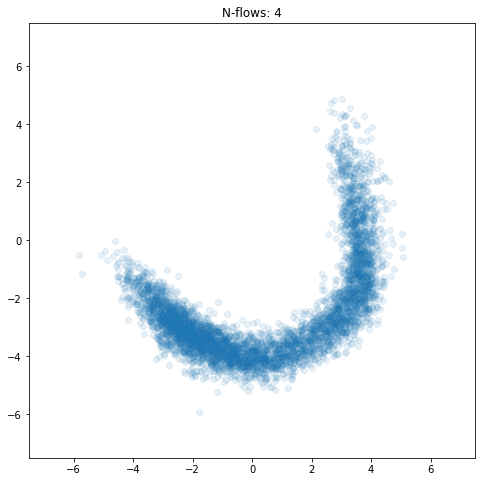

7.227710723876953
-1.6332224607467651
-2.039360523223877
-2.1143529415130615
-2.158047676086426
-2.224893569946289
-2.3200197219848633
-2.4321200847625732
-2.5237982273101807
-2.5679492950439453
-2.562753915786743
-2.608482837677002
-2.5885350704193115
-2.5790138244628906
-2.6208927631378174
-2.598677635192871
-2.6360654830932617
-2.596367597579956
-2.6085078716278076
-2.5970170497894287


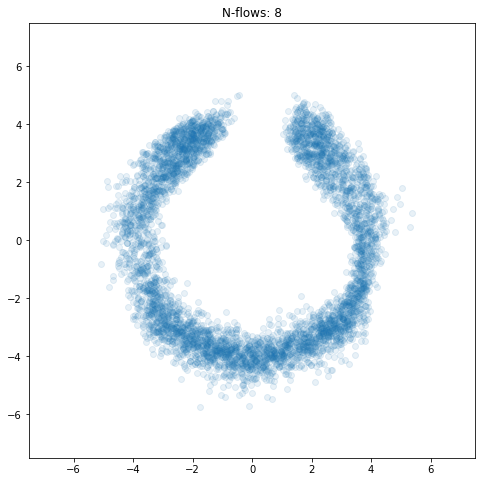

7.789675712585449
-1.4998537302017212
-2.0710737705230713
-2.1402716636657715
-2.293973207473755
-2.602153778076172
-2.6520471572875977
-2.66560697555542
-2.705259084701538
-2.7171711921691895
-2.701683521270752
-2.7155864238739014
-2.7236075401306152
-2.7183070182800293
-2.7170650959014893
-2.7138686180114746
-2.7275519371032715
-2.71669602394104
-2.730074882507324
-2.706491470336914


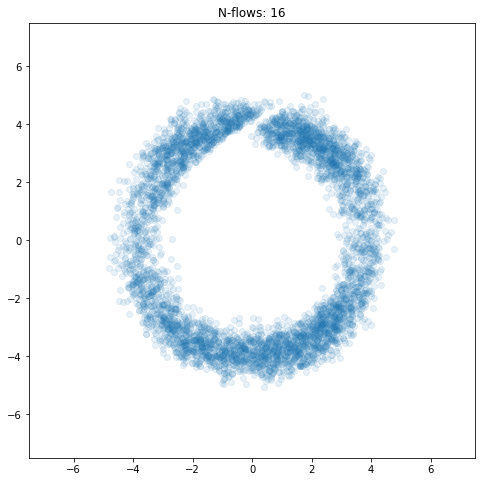

In [15]:
def show_samples(s, title):
    plt.figure(figsize=(8, 8))
    plt.scatter(s[:, 0], s[:, 1], alpha=0.1)
    plt.xlim(-7.5, 7.5)
    plt.ylim(-7.5, 7.5)
    plt.title(title)
    plt.show()


for n_flows in [4, 8, 16]:
    flow = Flow(dim=2, n_flows=n_flows)
    shape = (1000, 2)
    train_flow(flow, shape, epochs=5000)
    z0, zk, ldj, mu, log_var = flow((5000, 2))
    show_samples(zk.data, f"N-flows: {n_flows}")


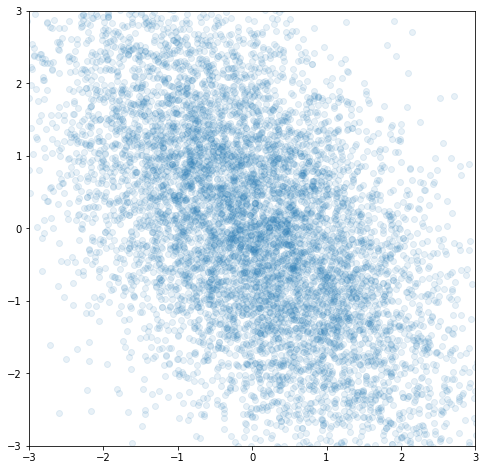

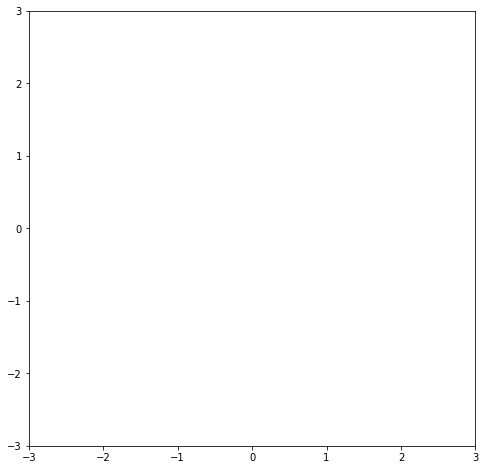

In [ ]:
for n in [2, 7, 10]:
    flow = Flow(dim=2, n_flows=n)
    train_flow(flow, target=target)
    z0, zk, ldj, mu, log_var = flow(target.shape)
    show_samples(zk.data)
#     show_z(zk.data, f"Gaussian prior, {n} flows")
